In [1]:
# Python Free Fermion Large Scale Simulation Platform (FreeFermiNet) Tutorials
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

# MaxCut

The Maxcut objective can be expressed by a classical Hamiltonian (with measurements only in Z basis). Such Hamiltonians nicely fit in the free Fermion formulation. In this example, we showcase how to use FreeFermiNet to solve a MaxCut problem, whose Hamiltonian is:

$H_{maxcut}=\frac{1}{2} \sum_{i<j} c_{ij}(I - Z_{i}Z_{j}).$

In this example, we use a simple quantum ansatz modeled by a multi-layer parametrized quantum circuit with related FreeFermiNet classes and functions.

We define one circuit gate Hamiltonian as $H_g$, and each gate corresponds to a continuous evolution $e^{-i\mathcal{H}_{g}t}$. A parametrized is a series of such evolutions:

$U_{total} = U_L U_{L-1}...U_{2} U_1, $

where $U_l$ is the $l$-th "layer" defined as:

$U_l = e^{-i\mathcal{H}_{l}t},$

where at each layer, $\mathcal{H}_{l}$ concerns interactionos of two Fermionic modes $i<j$, not necessarily nearest-neighbor. In this example, we use a simple construction (refer to Tutorial 1 for more details):

$\begin{equation}
    \begin{aligned}
        \mathcal{H}_{l} &=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+(c+di) a_i^{\dagger} a_j+(c-di) a_j^{\dagger} a_i \\ &= -\frac{1}{2} \left(b_{ii} Z_i + b_{jj} Z_j\right)+\frac{c}{2} \left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j + X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j \right)\\
        &+\frac{d}{2}\left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j - X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j \right),
    \end{aligned}
\end{equation}$

In [2]:
import os
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse, \
    mnist_single_pdf, mix_rbf_kernel, kernel_expect

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import qiskit # Qiskit is required for this demo
import math
import seaborn as sns


import torch
import matplotlib.pyplot as plt
import qiskit
import numpy as np
import networkx as nx
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import VQE, NumPyMinimumEigensolver

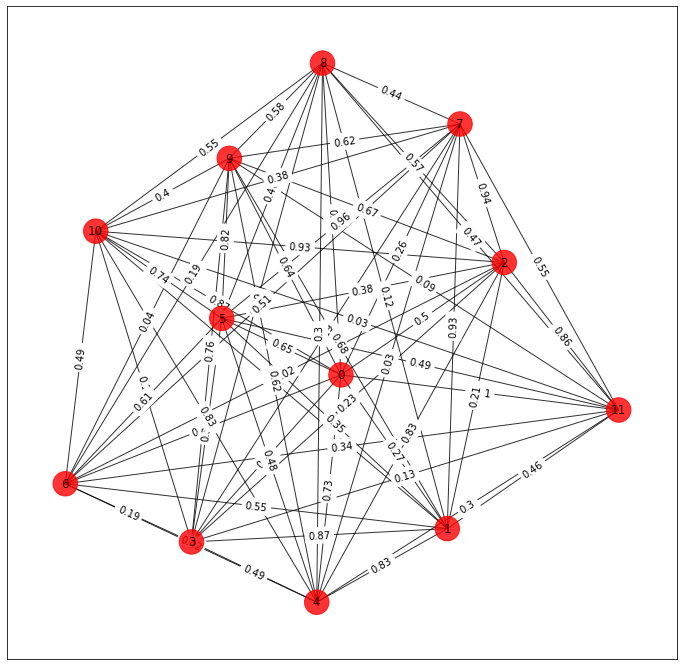

In [3]:
n_fermions = 12 # 12 nodes in graph
n_show_qubits = n_fermions

connections = [(5,0), (0, 1), (1, 2), (2, 3), (3, 4)] # NOT NECESSARY
#======================================Create p_data==========================================
hdim = 2**n_show_qubits
G = nx.Graph()
G.add_nodes_from([i for i in range(n_show_qubits)])

edges = []
for i in range(n_show_qubits):
    for j in range(n_show_qubits):
        if j > i:
            edges.append((i,j, round(np.random.rand(), 2) ))
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    plt.figure(3,figsize=(12,12)) 
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
W = np.zeros([n_show_qubits, n_show_qubits])
for i in range(n_show_qubits):
    for j in range(n_show_qubits):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            W[i, j] = temp["weight"]
print(W)

[[0.   0.27 0.5  0.62 0.73 0.65 0.96 0.26 0.83 0.64 0.87 0.81]
 [0.27 0.   0.21 0.87 0.83 0.35 0.55 0.93 0.12 0.68 0.37 0.46]
 [0.5  0.21 0.   0.23 0.83 0.38 0.02 0.94 0.57 0.67 0.93 0.86]
 [0.62 0.87 0.23 0.   0.49 0.36 0.19 0.19 0.89 0.76 0.15 0.13]
 [0.73 0.83 0.83 0.49 0.   0.48 0.42 0.03 0.3  0.62 0.83 0.3 ]
 [0.65 0.35 0.38 0.36 0.48 0.   0.61 0.96 0.46 0.82 0.74 0.49]
 [0.96 0.55 0.02 0.19 0.42 0.61 0.   0.51 0.19 0.04 0.49 0.34]
 [0.26 0.93 0.94 0.19 0.03 0.96 0.51 0.   0.44 0.62 0.38 0.55]
 [0.83 0.12 0.57 0.89 0.3  0.46 0.19 0.44 0.   0.58 0.55 0.47]
 [0.64 0.68 0.67 0.76 0.62 0.82 0.04 0.62 0.58 0.   0.4  0.09]
 [0.87 0.37 0.93 0.15 0.83 0.74 0.49 0.38 0.55 0.4  0.   0.03]
 [0.81 0.46 0.86 0.13 0.3  0.49 0.34 0.55 0.47 0.09 0.03 0.  ]]


In [5]:
# Solve for the exact solution with classical method
max_cut = Maxcut(W)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

Problem name: Max-cut

Maximize
  -0.54*x_0*x_1 - 1.74*x_0*x_10 - 1.62*x_0*x_11 - x_0*x_2 - 1.24*x_0*x_3
  - 1.46*x_0*x_4 - 1.3*x_0*x_5 - 1.92*x_0*x_6 - 0.52*x_0*x_7 - 1.66*x_0*x_8
  - 1.28*x_0*x_9 - 0.74*x_1*x_10 - 0.92*x_1*x_11 - 0.42*x_1*x_2 - 1.74*x_1*x_3
  - 1.66*x_1*x_4 - 0.7*x_1*x_5 - 1.1*x_1*x_6 - 1.86*x_1*x_7 - 0.24*x_1*x_8
  - 1.36*x_1*x_9 - 0.06*x_10*x_11 - 1.86*x_2*x_10 - 1.72*x_2*x_11 - 0.46*x_2*x_3
  - 1.66*x_2*x_4 - 0.76*x_2*x_5 - 0.04*x_2*x_6 - 1.88*x_2*x_7 - 1.14*x_2*x_8
  - 1.34*x_2*x_9 - 0.3*x_3*x_10 - 0.26*x_3*x_11 - 0.98*x_3*x_4 - 0.72*x_3*x_5
  - 0.38*x_3*x_6 - 0.38*x_3*x_7 - 1.78*x_3*x_8 - 1.52*x_3*x_9 - 1.66*x_4*x_10
  - 0.6*x_4*x_11 - 0.96*x_4*x_5 - 0.84*x_4*x_6 - 0.06*x_4*x_7 - 0.6*x_4*x_8
  - 1.24*x_4*x_9 - 1.48*x_5*x_10 - 0.98*x_5*x_11 - 1.22*x_5*x_6 - 1.92*x_5*x_7
  - 0.92*x_5*x_8 - 1.64*x_5*x_9 - 0.98*x_6*x_10 - 0.68*x_6*x_11 - 1.02*x_6*x_7
  - 0.38*x_6*x_8 - 0.08*x_6*x_9 - 0.76*x_7*x_10 - 1.1*x_7*x_11 - 0.88*x_7*x_8
  - 1.24*x_7*x_9 - 1.1*x_8*x_10 - 0.94*

In [6]:
# n = n_show_qubits
# best_cost_brute = 0
# for b in range(2**n):
#     x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
#     cost = 0
#     for i in range(n):
#         for j in range(n):
#             cost = cost + W[i, j] * x[i] * (1 - x[j])
#     if best_cost_brute < cost:
#         best_cost_brute = cost
#         xbest_brute = x
#     print("case = " + str(x) + " cost = " + str(cost))

# colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
# plt.figure(3,figsize=(8,6)) 
# draw_graph(G, colors, pos)
# print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

In [7]:
factor = 2
N = factor * n_show_qubits # Total qubits
basis_m_n = binary_basis(geometry=(n_show_qubits,)) # The basis in the probability space

conn_list = [ [np.min(p), np.max(p)] for p in get_nn_pairs(geometry=(N,))]*10

print('conn_list', conn_list)
L = len(conn_list) # Number of layers

# 101010...10
x_input = torch.tensor([[1,0]*int(N/2)]) if N%2==0 else torch.tensor([[1,0]*int(N/2)+[1]])

# Initialize the circuit
circuit = Network(conn_list, N)
print('circuit.parameters()', circuit.parameters())

# Initialize the circuit
circuit = Network(conn_list, N)

beta1 = 0.9
lr_G = 1e-1
optimizerG = torch.optim.Adam(circuit.parameters(), lr=lr_G, betas=(beta1, 0.999)) #The parameters are the th


conn_list [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [0, 23], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [0, 23], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [0, 23], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [0, 23], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23],

In [8]:
# pre-conpute the weight matrix W (symmetric) to save time
def maxcut_obj(x, G, W):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= W[i][j]
            
    return obj

# pl is the probability list (normalized or not), either exact or with sampling error
def compute_expectation(counts, x_strings, G, W):
    avg = 0
    sum_count = 0
    for i in range(len(counts)):
        bitstring = x_strings[i]
        count = counts[i]
        obj = maxcut_obj(bitstring, G, W)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [9]:
n_space = basis_m_n.shape[0] # The number of total probability patterns
batchsize = 1024*10
num_batches = n_space//batchsize if n_space%batchsize==0 else n_space//batchsize+1
obj_list = []
for itr in range(20): # At each iteration, measure the kl divergence and update
    #probs_theta_valid_samples = torch.zeros(bas_samples.shape[0]) # to collect the model probabilities at valid patterns
    pdf_model = torch.zeros(basis_m_n.shape[0]) # To keep full pdf for exact calculation of the MMD loss

    ts = time.time()
    circuit.zero_grad() # clear the parameter gradients
    obj = torch.tensor(0.0)
    # Loop through all possible patterns in the total probability space
    for i in range(num_batches):
        y_batch = basis_m_n[i*batchsize:(i+1)*batchsize]
        x_batch = x_input.repeat_interleave(y_batch.shape[0], axis=0)
        sub_mask_batch = (torch.tensor([ [1]*(N//factor)+[0]*(N-N//factor) ])).repeat(y_batch.shape[0], 1) # Measure the first half of the qubits

        probs_batch = circuit.forward_partial_observation(y_batch, x_batch, sub_mask_batch)
        # probs_batch = torch.conj(amps_batch)*amps_batch # this is still torch.cfloat
        # Only keep the real part, as all information goes to the real part
        probs_batch = probs_batch.real
        #print('probs_batch', probs_batch)
        pdf_model[i*batchsize:(i+1)*batchsize] = probs_batch # Keep track of the gradient, as this directly goes into the loss calculation

    tf = time.time()
    # in the case of calculating the exact MMD loss, which cannot be written as a sum
    obj = compute_expectation(pdf_model, basis_m_n, G, W)
    print('iter, obj, time', (itr, obj, tf-ts))
    obj.backward()
    optimizerG.step()
    
    obj_list.append(obj)

    if itr % 1 == 0:
        plt.plot(pdf_model.detach().numpy(), 'x-')
        plt.savefig('kl_training_figs/iter_'+str(itr)+'.png')
        plt.close()

        # plot the gradients
        grads_l_list = []
        for l in range(L):
            # each layer has four parameters
            grads_l = np.array([[circuit.V_l_module_list[l].bii.grad.detach().numpy()[0], circuit.V_l_module_list[l].bjj.grad.detach().numpy()[0],\
             circuit.V_l_module_list[l].bij_real.grad.detach().numpy()[0], \
            circuit.V_l_module_list[l].bij_img.grad.detach().numpy()[0]]])

            grads_l_list.append(grads_l)

        grads_4_by_l = np.concatenate(grads_l_list, axis=0).T

        ax = sns.heatmap( grads_4_by_l , linewidth = 0.5 , cmap = 'coolwarm' )
        plt.xlabel('layer No.')
        plt.ylabel('thetas 0, 1, 2, 3')
        plt.savefig('kl_training_gradients/iter_'+str(itr)+'.png')
        plt.close()


iter, obj, time (0, tensor(-17.7563, grad_fn=<DivBackward0>), 3.155601739883423)
iter, obj, time (1, tensor(-18.0549, grad_fn=<DivBackward0>), 2.942063093185425)
iter, obj, time (2, tensor(-18.1916, grad_fn=<DivBackward0>), 3.69222092628479)
iter, obj, time (3, tensor(-18.9390, grad_fn=<DivBackward0>), 3.3400402069091797)
iter, obj, time (4, tensor(-19.1681, grad_fn=<DivBackward0>), 3.162264108657837)
iter, obj, time (5, tensor(-19.8329, grad_fn=<DivBackward0>), 3.158961057662964)
iter, obj, time (6, tensor(-20.3988, grad_fn=<DivBackward0>), 3.4878652095794678)
iter, obj, time (7, tensor(-20.7165, grad_fn=<DivBackward0>), 3.124340057373047)
iter, obj, time (8, tensor(-20.7902, grad_fn=<DivBackward0>), 3.038015842437744)
iter, obj, time (9, tensor(-21.1065, grad_fn=<DivBackward0>), 4.174059867858887)
iter, obj, time (10, tensor(-21.3732, grad_fn=<DivBackward0>), 2.9500362873077393)
iter, obj, time (11, tensor(-21.3890, grad_fn=<DivBackward0>), 3.140435218811035)
iter, obj, time (12, ten

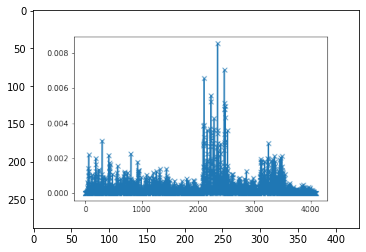

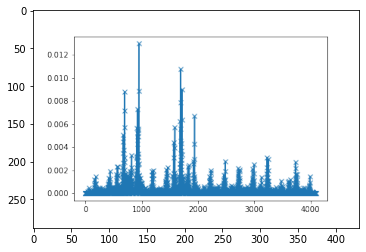

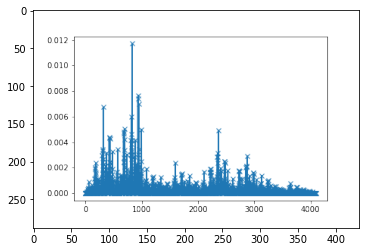

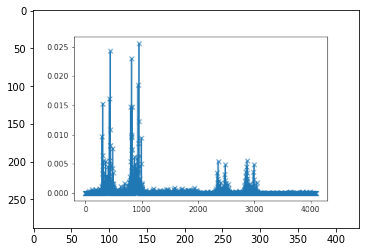

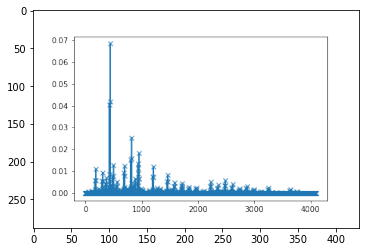

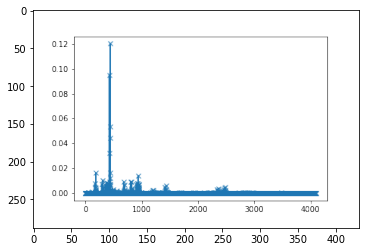

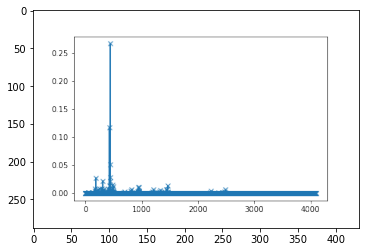

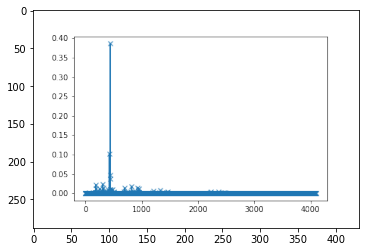

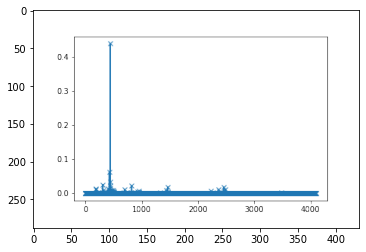

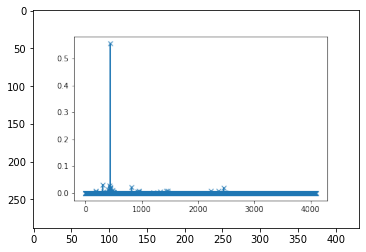

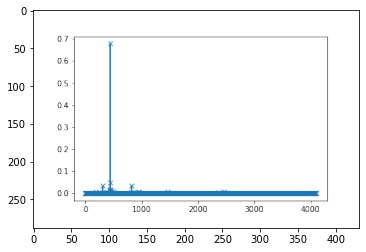

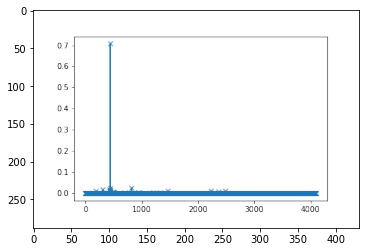

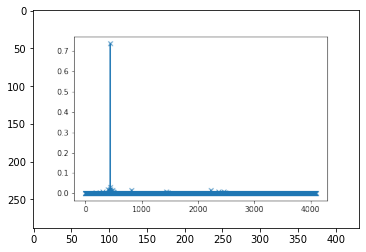

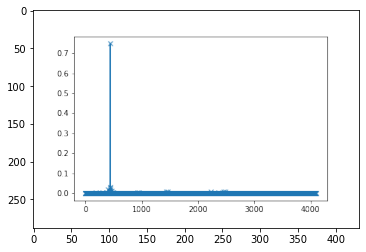

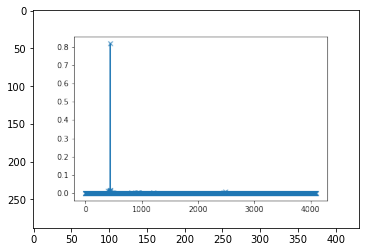

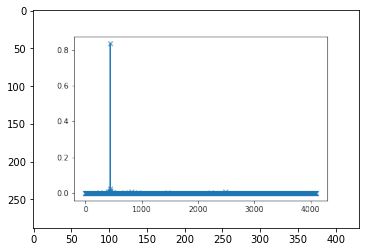

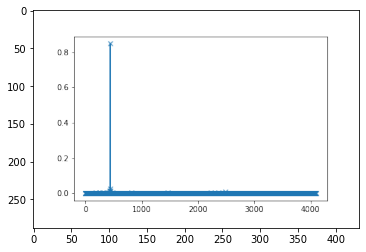

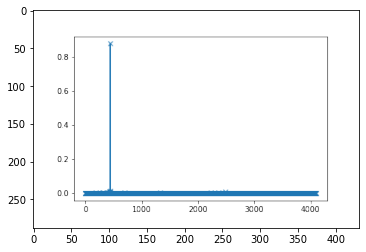

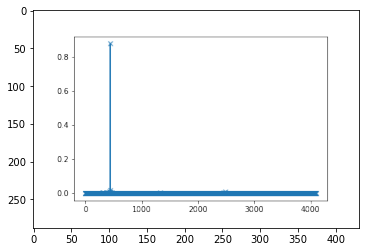

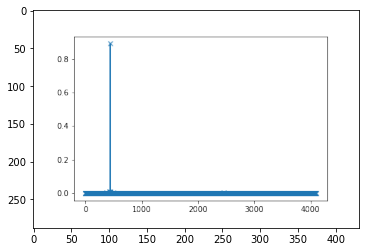

In [10]:
import matplotlib.image as mpimg
# Plot the learning results (probability of observing each bit string)
for itr in range(20):
    img = mpimg.imread('kl_training_figs/iter_'+str(itr)+'.png')
    imgplot = plt.imshow(img)
    plt.show()

/var/folders/66/87ywc69x2c5_cqkhm3p3f4l00000gn/T/ipykernel_65862/113228053.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obj_list = torch.tensor(obj_list)


Text(0.5, 1.0, 'optimal value -21.94')

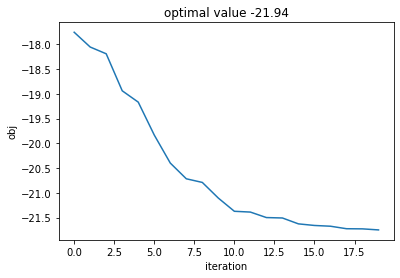

In [18]:
# Plot the learnt objective function at each iteration
obj_list = torch.tensor(obj_list)
plt.plot(obj_list)
plt.xlabel('iteration')
plt.ylabel('obj')
plt.title('optimal value '+str(-result.fval))

In [16]:
result.fval

21.94